In [1]:
import numpy
import scipy
import everest
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)

EPIC_id = 212521166        
star = everest.Everest(EPIC_id)
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')

trend = scipy.signal.medfilt(y, 25)
y_filt = y /trend
y_filt = sigma_clip(y_filt, sigma_upper=2, sigma_lower=float('inf'))

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("Flux (electrons per sec)")
ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalized flux");

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 212521166.


In [2]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(t, y_filt)
results = model.power()

  0%|          | 0/8368 periods | 00:00<?

Transit Least Squares TLS 1.0.22 (15 February 2019)
Creating model cache for 36 durations
Searching 3402 data points, 8368 periods from 0.602 to 39.454 days
Using all 8 CPU threads


100%|██████████| 8368/8368 periods | 00:09<00:00 


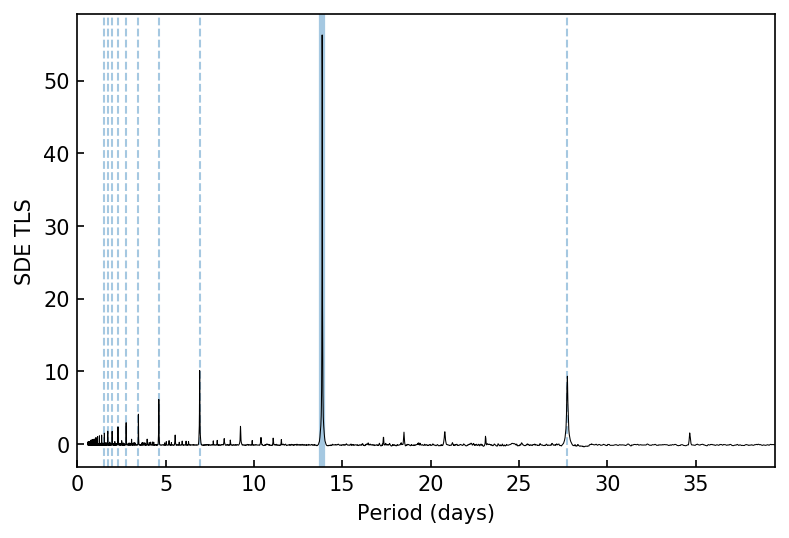

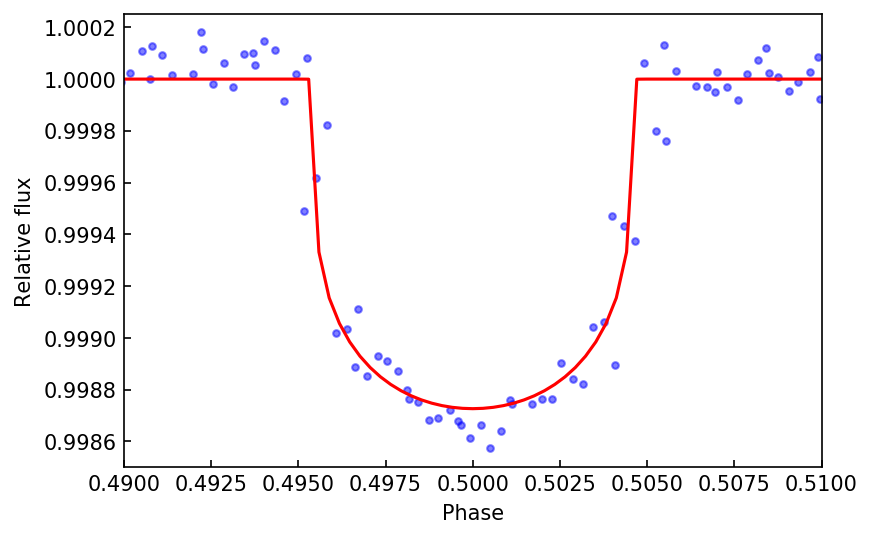

In [3]:
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE TLS')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red')
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.ylim(0.9985, 1.00025)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

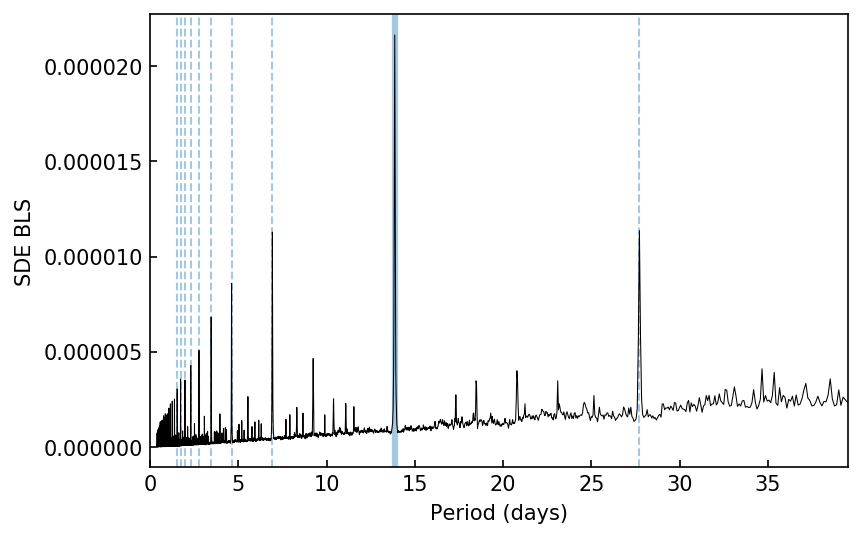

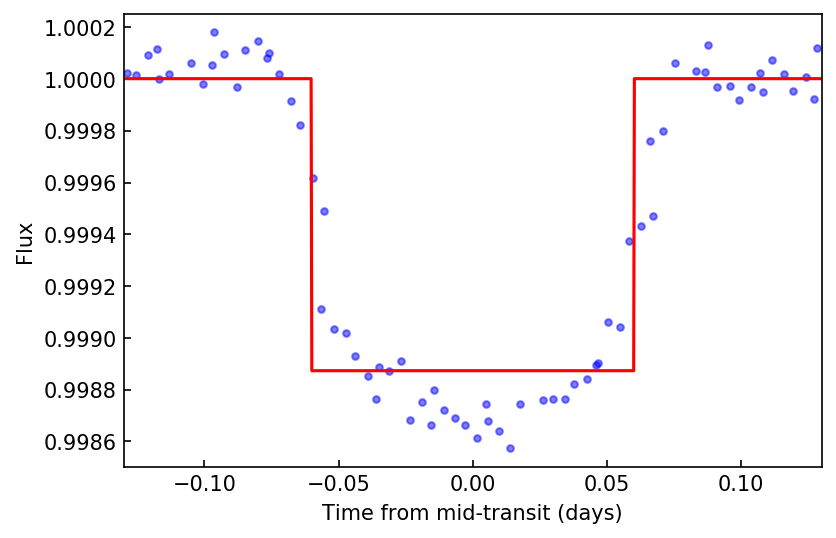

In [4]:
from astropy.stats import BoxLeastSquares
durations = numpy.linspace(0.05, 0.2, 20)
model_bls = BoxLeastSquares(t, y_filt)
results_bls = model_bls.autopower(durations, frequency_factor=10)
period = results_bls.period[numpy.argmax(results_bls.power)]

plt.figure()
ax = plt.gca()
ax.axvline(period, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE BLS')
plt.xlabel('Period (days)')
plt.plot(results_bls.period, results_bls.power, color='black', lw=0.5)
plt.xlim(0, max(results_bls.period));

index = numpy.argmax(results_bls.power)
period = results_bls.period[index]
t0 = results_bls.transit_time[index]
duration = results_bls.duration[index]

plt.figure()
ax = plt.gca()
x = (t - t0 + 0.5*period) % period - 0.5*period
m = numpy.abs(x) < 0.5
plt.scatter(
    x[m],
    y_filt[m],
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
x = numpy.linspace(-0.13, 0.13, 1000)
f = model_bls.model(x + t0, period, duration, t0)
ax.plot(x, f, color='red')
ax.set_xlim(-0.13, 0.13)
plt.ylim(0.9985, 1.00025)
ax.set_xlabel("Time from mid-transit (days)")
ax.set_ylabel("Flux");